In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Insert the directory
import sys
sys.path.insert(0,"/content/drive/My Drive/TSOAI/S6")

In [3]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torchsummary import summary
#from model import Net
from model import Train,NetBatchNorm,NetDilated
from utils import display_model_summary,calculate_mean_std,imshow,im_convert,im_convert_numpy,find_misclassified_images,display_missclassfied_images
from dataset import Cifar10Dataset,DataTransformation
import numpy as np
import torchvision
import albumentations
import albumentations as A
import albumentations.pytorch
from albumentations.pytorch import ToTensorV2

In [4]:
mean,std = calculate_mean_std("CIFAR10")

Files already downloaded and verified


In [5]:
data_transformation = DataTransformation(mean,std)

In [6]:
train = Cifar10Dataset(transform=data_transformation.train)
test = Cifar10Dataset(train=False,transform=data_transformation.test)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [9]:
params = {
    "model": "cifar10dilated",
    "seed":1,
    "lr": 0.1,
    "batch_size": 256,
    "num_workers": 4,
    "epochs": 80,
}

In [10]:
#SEED = 1

# CUDA?

cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(params["seed"])


if cuda:
    torch.cuda.manual_seed(params["seed"])

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=params["batch_size"], num_workers=params["num_workers"], pin_memory=True) if cuda else dict(shuffle=True, batch_size=params["batch_size"])

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [11]:
def display_images(images,label,num):
  fig = plt.figure(figsize=(25, 4))

  # We plot 4 images from our train_dataset
  for idx in np.arange(num):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx])) #converting to numpy array as plt needs it.
    ax.set_title(classes[labels[idx].item()])


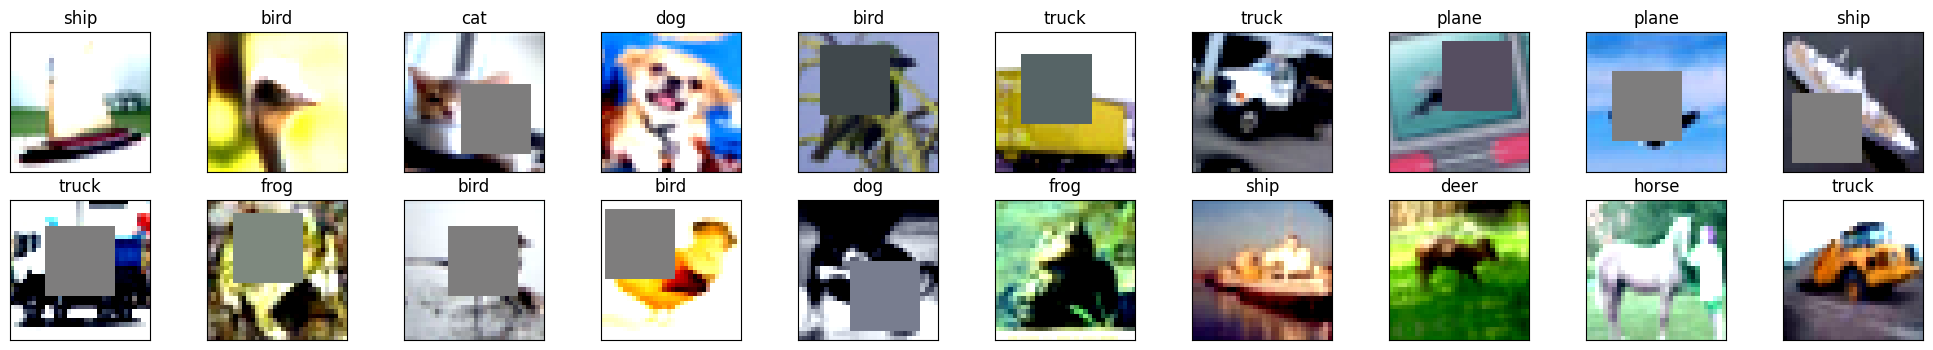

In [12]:
# We iter the batch of images to display
dataiter = iter(train_loader) # converting our train_dataloader to iterable so that we can iter through it.
images, labels = next(dataiter) #going from 1st batch of 4 images to the next batch
#print(images[0].shape)
display_images(images,labels,20)

In [13]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
# instantiate the model and load it to the device
model = NetDilated().to(device)
#model structure
display_model_summary(model,input_structure=(3,32,32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
              ReLU-2           [-1, 64, 32, 32]               0
       BatchNorm2d-3           [-1, 64, 32, 32]             128
         Dropout2d-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]          73,728
              ReLU-6          [-1, 128, 32, 32]               0
       BatchNorm2d-7          [-1, 128, 32, 32]             256
         Dropout2d-8          [-1, 128, 32, 32]               0
            Conv2d-9           [-1, 64, 16, 16]           8,256
             ReLU-10           [-1, 64, 16, 16]               0
           Conv2d-11           [-1, 64, 16, 16]          36,864
             ReLU-12           [-1, 64, 16, 16]               0
      BatchNorm2d-13           [-1, 64, 16, 16]             128
        Dropout2d-14           [-1

In [15]:
# set up the optimizer with model parameters , learning rate and momentum
optimizer = optim.Adam(model.parameters(),lr=0.1)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,'min')
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.1)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,max_lr=0.9, steps_per_epoch=len(train_loader), epochs=175)
criterion = nn.CrossEntropyLoss()

In [16]:
train_instance = Train(model,device,criterion,optimizer,scheduler,train_loader,test_loader,num_epochs=175,batch_size=params["batch_size"])

In [17]:
train_instance()

epoch : 1
training loss: 0.0074, acc 30.44% 
validation loss: 0.0063, validation acc 42.01% 
epoch : 2
training loss: 0.0064, acc 40.34% 
validation loss: 0.0056, validation acc 49.53% 
epoch : 3
training loss: 0.0059, acc 45.73% 
validation loss: 0.0052, validation acc 53.35% 
epoch : 4
training loss: 0.0055, acc 49.97% 
validation loss: 0.0048, validation acc 56.76% 
epoch : 5
training loss: 0.0052, acc 52.46% 
validation loss: 0.0045, validation acc 60.24% 
epoch : 6
training loss: 0.0050, acc 54.50% 
validation loss: 0.0044, validation acc 60.95% 
epoch : 7
training loss: 0.0048, acc 56.60% 
validation loss: 0.0042, validation acc 63.03% 
epoch : 8
training loss: 0.0046, acc 58.01% 
validation loss: 0.0039, validation acc 66.03% 
epoch : 9
training loss: 0.0045, acc 59.29% 
validation loss: 0.0039, validation acc 66.67% 
epoch : 10
training loss: 0.0044, acc 61.08% 
validation loss: 0.0037, validation acc 67.53% 
epoch : 11
training loss: 0.0043, acc 61.41% 
validation loss: 0.0038

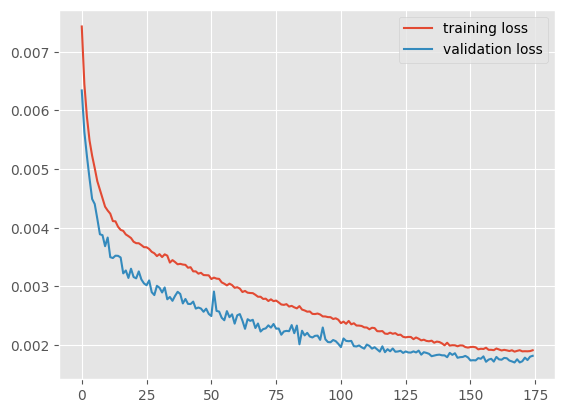

In [18]:
plt.style.use('ggplot')
plt.plot(train_instance.running_loss_history, label='training loss')
plt.plot(train_instance.val_running_loss_history, label='validation loss')
plt.legend()

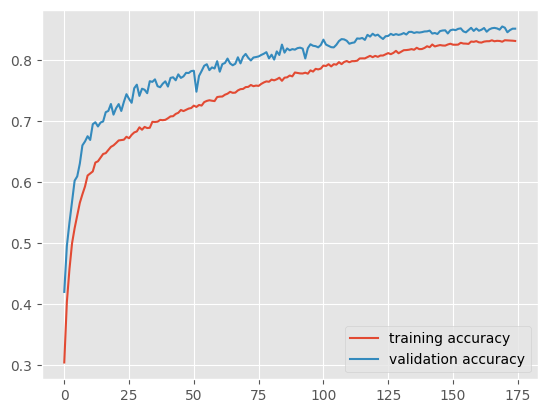

In [19]:
plt.style.use('ggplot')
plt.plot([i.cpu().detach().numpy() for i in train_instance.running_corrects_history], label='training accuracy')
plt.plot([i.cpu().detach().numpy() for i in train_instance.val_running_corrects_history], label='validation accuracy')
plt.legend()

In [21]:
misclassified_images,misclassified_labels,true_labels=find_misclassified_images(15,test_loader,device,model)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


<Figure size 2500x400 with 0 Axes>

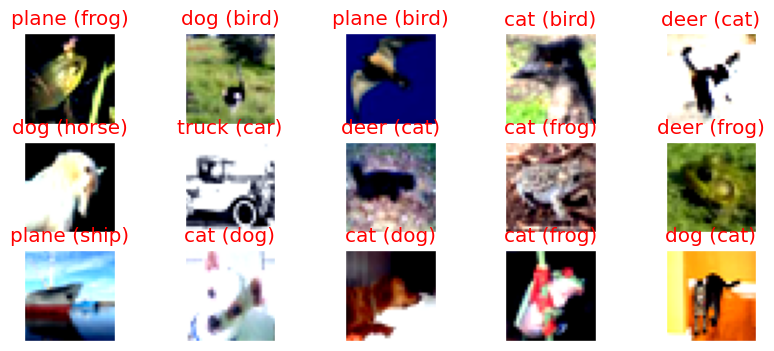

In [22]:
display_missclassfied_images(misclassified_images,classes)